# Neural models for word vector representation

## Language Modelling Assignment - 2023/24

### Milton Gangopadhyay

In the realm of natural language processing (NLP), the quest for effective word representation is paramount. Neural models have emerged as frontrunners in this pursuit, offering versatile and nuanced approaches to encoding semantic and syntactic information into compact vector spaces. These models, ranging from classic techniques like Word2Vec to sophisticated transformer architectures, revolutionize how machines understand and manipulate language.

This notebook aims at developing two different models:

1) **Model based on the prediction of words given their context:** This model will take as input the context (n words both preceding and following) of a given word (target), and try to predict this target word. Therefore, the input to the model will be a set of context words, and the output will be the predicted target word.

2) **Model based on context prediction given a word:** Unlike the previous model, this approach takes a single word as input and aims to predict the words that usually appear around it, i.e. its context. The input data structure will simply consist of the target word, while the output generated by the model will be the words expected to be found in their immediate context.

The code structure is as follows:

**Part 0** - This part deals with the importation of the required packages for this task, such as `Keras`, `nltk`, `numpy` and others, along with the necessary functions from the `functions.py` Python file, that was developed alongside this notebook.

**Part 1** - This part deals with developing the model based on the prediction of words given their context, along with its t-SNE visualisation.

**Part 2** - This part deals with developing the second model, that is, a model based on context prediction given a word, along with its t-SNE visualisation and cosine similarity.

## Part 0

In this part, all the necessary libraries will be imported, along with the functions from the `functions.py` file.

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from functions import *
import random

import random
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')

books_paths = ["game_of_thrones.txt", "the_fellowship_of_the_ring.txt", "harry_potter_and_the_philosophers_stone.txt"]
tokenizer = Tokenizer()
content_generator = read_files(books_paths)
filtered_words = remove_stop_words(content_generator, exceptions=['he', 'she']) # because they exist in target words list
filtered_words = list(filtered_words)
sequences, word_index, vocab_size = tokenize(filtered_words, tokenizer)

with open("materials/target_words_harry_potter.txt", "r") as file:
    target_words = [word.strip() for word in file.readlines()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Milton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1

In this part, we train two models of different embedding sizes and then compare their result in terms of accuracy, cosine similarity and computational requirements. 

In [55]:
window_size = 7
data = create_training_data(sequences, window_size)

# Data Preparation - directly use indices instead of one-hot encoding
context, targets = zip(*data)
context = np.array(context)
targets = np.array(targets) 

# Split the data
x_train, x_val, y_train, y_val = train_test_split(context, targets, test_size=0.1, random_state=42)

In [7]:
print("Number of targets:", len(targets))
print("Number of contexts:", len(context))

Number of targets: 191170
Number of contexts: 191170


In [8]:
#First model with embedding output dimension of 100

embedding_output_dim = 100
lstm_neurons= 64
activation = 'softmax'
optimizer = 'adam'

text_predictor_model = create_model(embedding_output_dim, vocab_size, lstm_neurons, activation, optimizer, window_size)

text_predictor_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 100)            1471000   
                                                                 
 bidirectional (Bidirection  (None, 6, 128)            63744     
 al)                                                             
                                                                 
 dense (Dense)               (None, 6, 128)            16512     
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 14710)             1897590   
                                                      

### Random embeddings - before training

Here we're creating a baseline that helps us visualise the learning of the algorithm when compared to its untrained form.

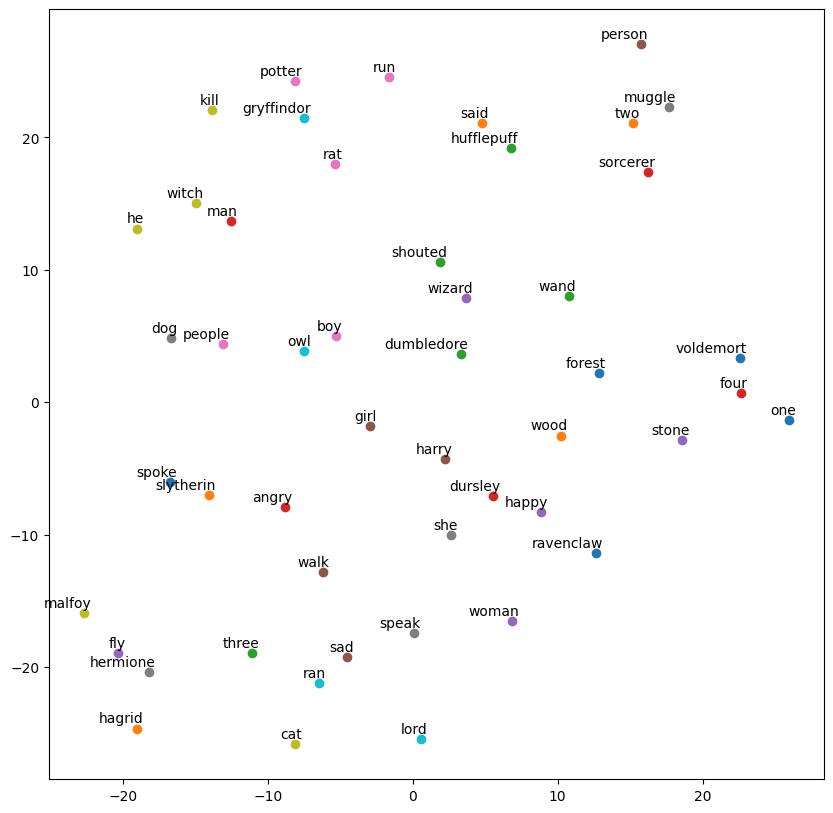

In [9]:
initial_embeddings = text_predictor_model.get_layer('embedding').get_weights()[0]

visualize_tsne_embeddings(target_words, initial_embeddings, word_index)

From the above, we see that the grouping is very random. This will help us compare the results of the model after it's trained.

In [10]:
history = text_predictor_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


5377/5377 [==============================] - 511s 94ms/step - loss: 7.9544 - accuracy: 0.0341 - val_loss: 7.8715 - val_accuracy: 0.0352
Epoch 2/10
5377/5377 [==============================] - 472s 88ms/step - loss: 7.6433 - accuracy: 0.0398 - val_loss: 7.7845 - val_accuracy: 0.0429
Epoch 3/10
5377/5377 [==============================] - 474s 88ms/step - loss: 7.3220 - accuracy: 0.0475 - val_loss: 7.7084 - val_accuracy: 0.0485
Epoch 4/10
5377/5377 [==============================] - 477s 89ms/step - loss: 6.9867 - accuracy: 0.0544 - val_loss: 7.7193 - val_accuracy: 0.0538
Epoch 5/10
5377/5377 [==============================] - 497s 92ms/step - loss: 6.6728 - accuracy: 0.0626 - val_loss: 7.8635 - val_accuracy: 0.0580
Epoch 6/10
5377/5377 [==============================] - 490s 91ms/step - loss: 6.3843 - accuracy: 0.0707 - val_loss: 8.0026 - val_accuracy: 0.0599
Epoch 7/10
5377/5377 [==============================] - 483s 90ms/step - loss: 6.1169 - accuracy: 0.0787 - val_loss:

`Execution Time - 80 minutes`

Although accuracy seems very low, it's not the main metric and does not necessitate a high value, as the target is to have learned embeddings, more than having a model that can predict the right missing word, where more than one could be right, normally speaking, in the language. Hence, this notebook will take a look on the t-SNE embeddings and closest words, in addition to the loss and accuracy as an evaluation criteria.

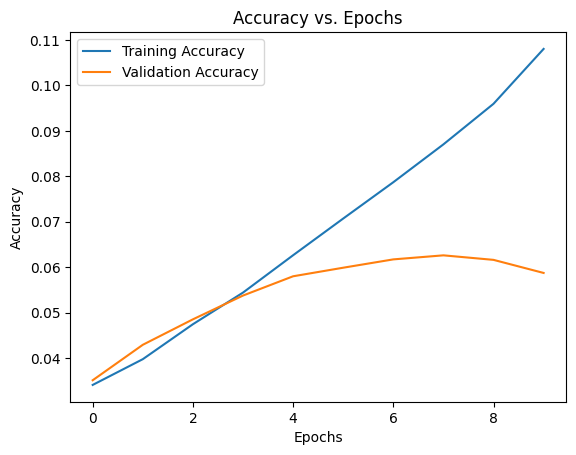

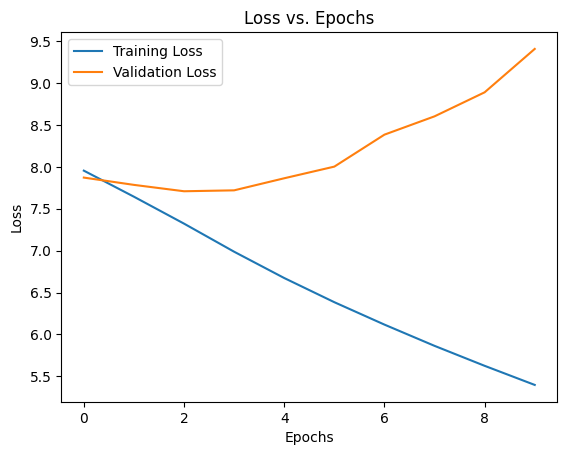

In [11]:
plot_accuracy(history)
plot_loss(history)

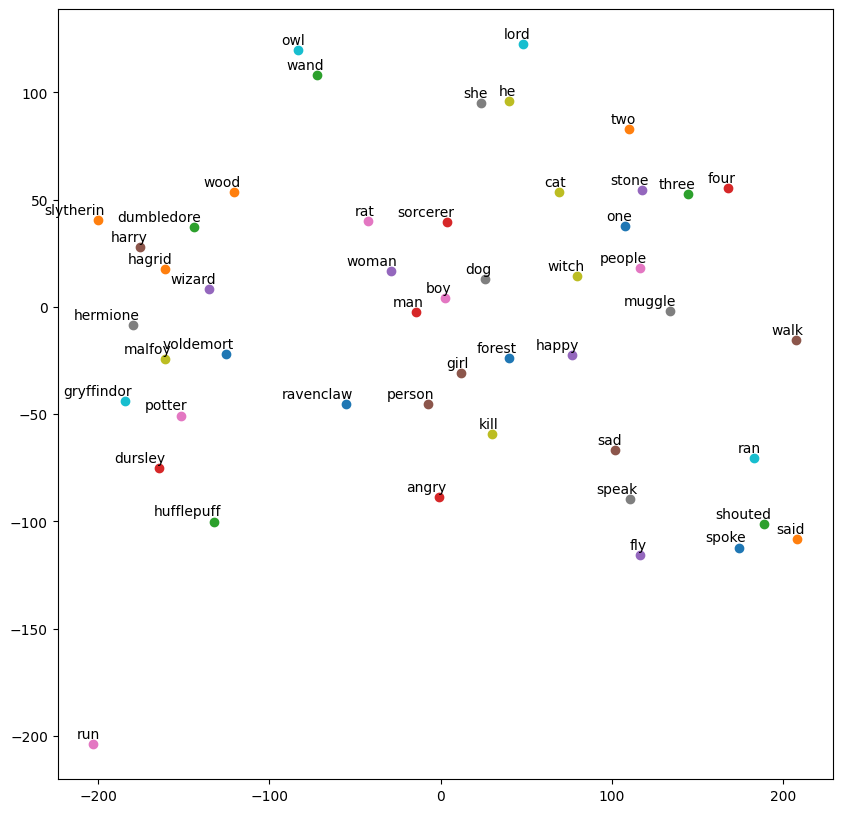

In [12]:
trained_embeddings = text_predictor_model.get_layer('embedding').get_weights()[0]
visualize_tsne_embeddings(target_words, trained_embeddings, word_index)

In [13]:
for _ in range(10):
    random_index = random.randint(0, len(target_words) - 1)
    word = target_words[random_index]
    closest_words = find_closest_words(word, word_index, trained_embeddings)
    print(f"Closest words to '{word}': {closest_words}")

Closest words to 'owl': [('wand', '52%'), ('yelling', '50%'), ('snapes', '49%'), ('tips', '49%'), ('frosted', '48%'), ('lumpy', '48%'), ('exam', '48%'), ('mossy', '48%'), ('hipped', '48%'), ('flocking', '47%')]
Closest words to 'sorcerer': [('lacking', '59%'), ('slides', '58%'), ('vagabond', '56%'), ('unfading', '56%'), ('flattering', '56%'), ('stamps', '54%'), ('putouter', '53%'), ('bricks', '52%'), ('thingols', '52%'), ('kid', '52%')]
Closest words to 'dumbledore': [('quirrell', '69%'), ('flitwick', '67%'), ('mcgonagall', '66%'), ('hagrid', '65%'), ('butterbur', '60%'), ('snape', '60%'), ('apurpose', '59%'), ('filch', '58%'), ('flamel', '57%'), ('firenze', '57%')]
Closest words to 'dog': [('hairs', '51%'), ('marks', '47%'), ('couldve', '46%'), ('ose', '45%'), ('balance', '45%'), ('ge', '44%'), ('threads', '44%'), ('fitted', '43%'), ('erupted', '43%'), ('tackling', '43%')]
Closest words to 'gryffindor': [('malkin', '54%'), ('seeker', '53%'), ('team', '51%'), ('zoo', '51%'), ('loads', 

We can see that the learned embeddings are so different from the random ones. They make sense, as an example the verbs are grouped togother as a cluster, indeed there are many clusters like people(different in age and gender segments). From this point, we will do expirements by chaning some hyperparameters of the model, like the embedding output dimension, and observe the differences, at the end the ultimate goal is to choose the better model

Now, we'll try a different model with different embedding output dimension and compare the results

In [25]:
embedding_output_dim = 50
lstm_neurons= 64
activation = 'softmax'
optimizer = 'adam'

text_predictor_model_2 = create_model(embedding_output_dim, vocab_size, lstm_neurons, activation, optimizer, window_size)

text_predictor_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 6, 50)             735500    
                                                                 
 bidirectional_1 (Bidirecti  (None, 6, 128)            44544     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 6, 128)            16512     
                                                                 
 dropout_1 (Dropout)         (None, 6, 128)            0         
                                                                 
 lambda_1 (Lambda)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 14710)             1897590   
                                                      

In [27]:
history = text_predictor_model_2.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
5377/5377 [==============================] - 396s 72ms/step - loss: 7.9484 - accuracy: 0.0339 - val_loss: 7.8601 - val_accuracy: 0.0343
Epoch 2/10
5377/5377 [==============================] - 352s 66ms/step - loss: 7.6487 - accuracy: 0.0392 - val_loss: 7.8193 - val_accuracy: 0.0443
Epoch 3/10
5377/5377 [==============================] - 355s 66ms/step - loss: 7.3526 - accuracy: 0.0467 - val_loss: 7.7023 - val_accuracy: 0.0487
Epoch 4/10
5377/5377 [==============================] - 351s 65ms/step - loss: 7.0478 - accuracy: 0.0530 - val_loss: 7.6890 - val_accuracy: 0.0541
Epoch 5/10
5377/5377 [==============================] - 354s 66ms/step - loss: 6.7635 - accuracy: 0.0604 - val_loss: 7.7601 - val_accuracy: 0.0580
Epoch 6/10
5377/5377 [==============================] - 355s 66ms/step - loss: 6.4996 - accuracy: 0.0679 - val_loss: 7.8961 - val_accuracy: 0.0621
Epoch 7/10
5377/5377 [==============================] - 352s 65ms/step - loss: 6.2546 - accuracy: 0.0737 - val_loss: 8

`Execution Time - 60 minutes`

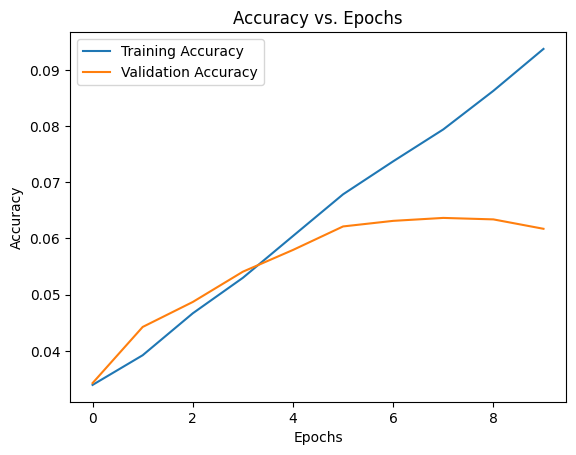

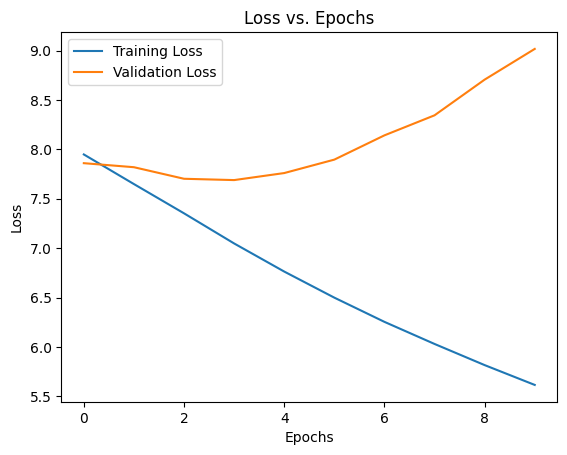

In [28]:
plot_accuracy(history)
plot_loss(history)

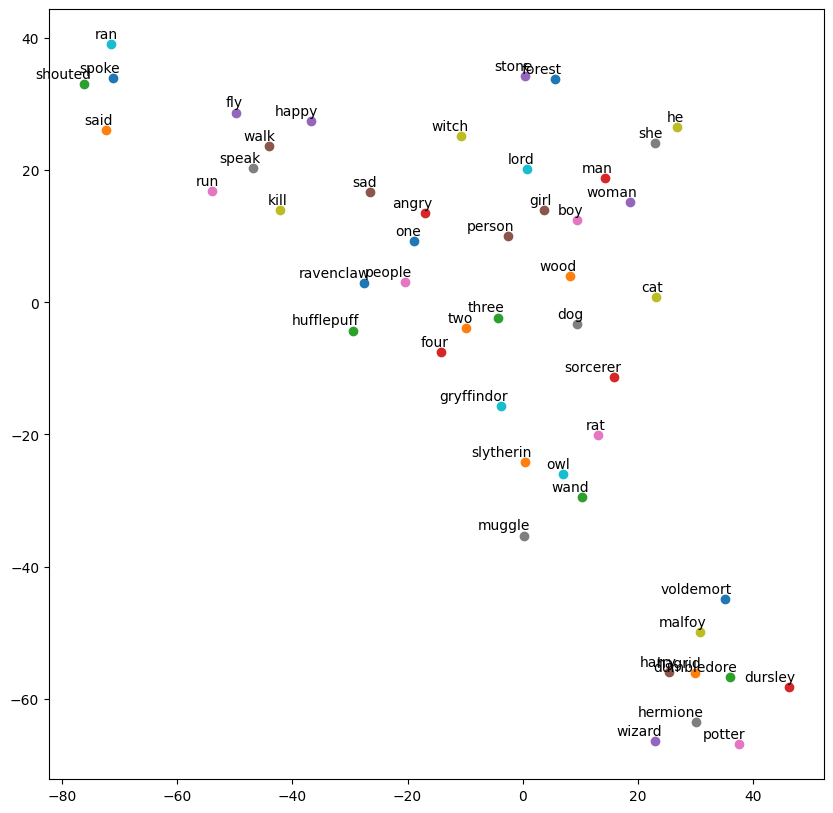

In [30]:
trained_embeddings = text_predictor_model_2.get_layer('embedding_1').get_weights()[0]
visualize_tsne_embeddings(target_words, trained_embeddings, word_index)

In [31]:
for _ in range(10):
    random_index = random.randint(0, len(target_words) - 1)
    word = target_words[random_index]
    closest_words = find_closest_words(word, word_index, trained_embeddings)
    print(f"Closest words to '{word}': {closest_words}")

Closest words to 'cat': [('dread', '58%'), ('carefully', '57%'), ('baggage', '57%'), ('marching', '56%'), ('swam', '55%'), ('dipped', '54%'), ('paddle', '54%'), ('rafters', '53%'), ('lie', '53%'), ('trailed', '52%')]
Closest words to 'wood': [('yehd', '57%'), ('broomsticks', '57%'), ('farmer', '54%'), ('daughterinlaw', '54%'), ('goldberry', '54%'), ('hurts', '53%'), ('bowl', '53%'), ('scars', '52%'), ('percy', '52%'), ('boy', '51%')]
Closest words to 'cat': [('dread', '58%'), ('carefully', '57%'), ('baggage', '57%'), ('marching', '56%'), ('swam', '55%'), ('dipped', '54%'), ('paddle', '54%'), ('rafters', '53%'), ('lie', '53%'), ('trailed', '52%')]
Closest words to 'one': [('first', '62%'), ('verse', '57%'), ('last', '56%'), ('vanish', '54%'), ('angry', '54%'), ('nothing', '54%'), ('trek', '53%'), ('perhaps', '53%'), ('yet', '52%'), ('things', '52%')]
Closest words to 'gryffindor': [('platforms', '57%'), ('book', '56%'), ('rations', '55%'), ('cup', '55%'), ('astronomy', '55%'), ('school'

We find that the second model, with a lower embedding output dimension, not only provided better result, but was also less computationally expensive, resulting in a lower execution time.

## Part 2

In this part, we'll train two models once again with similar attributes but different output embedding dimensions. The idea is to try and obtain better results in terms of functionality while being computationally efficient.

In [41]:
nltk.download('stopwords')

books_paths = ["game_of_thrones.txt", "the_fellowship_of_the_ring.txt", "harry_potter_and_the_philosophers_stone.txt"]
tokenizer = Tokenizer()
content_generator = read_files(books_paths)
filtered_words = remove_stop_words(content_generator, exceptions=['he', 'she']) # because they exist in target words list
filtered_words = list(filtered_words)
sequences, word_index, vocab_size = tokenize(filtered_words, tokenizer)

with open("materials/target_words_harry_potter.txt", "r") as file:
    target_words = [word.strip() for word in file.readlines()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Milton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
window_size = 7
data = create_training_data2(sequences, window_size)

# Separating the target and context words
targets, contexts = zip(*data)
targets = np.array(targets)
contexts = np.array(contexts)

# Splitting the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(targets, contexts, test_size=0.1, random_state=42)

In [43]:
print("Number of targets:", len(targets))
print("Number of contexts:", len(contexts))

Number of targets: 1147020
Number of contexts: 1147020


In [44]:
embedding_output_dim = 100

lstm_neurons= 64
optimizer = 'adam'
activation='sigmoid'

context_predictor_model = create_context_model(embedding_output_dim, vocab_size, activation, optimizer)

context_predictor_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_word_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 context_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 shared_embedding (Embeddin  (None, 1, 100)               1471000   ['target_word_input[0][0]',   
 g)                                                                  'context_input[0][0]']       
                                                                                            

In [45]:
history = context_predictor_model.fit([x_train, y_train], np.ones(len(y_train)), epochs=10, batch_size=32, validation_data=([x_val, y_val], np.ones(len(y_val))))

Epoch 1/10
32260/32260 [==============================] - 1135s 35ms/step - loss: 0.0348 - accuracy: 0.9999 - val_loss: 4.8065e-07 - val_accuracy: 1.0000
Epoch 2/10
32260/32260 [==============================] - 1165s 36ms/step - loss: 5.1675e-08 - accuracy: 1.0000 - val_loss: 1.8223e-08 - val_accuracy: 1.0000
Epoch 3/10
32260/32260 [==============================] - 1160s 36ms/step - loss: 1.5848e-08 - accuracy: 1.0000 - val_loss: 1.6066e-08 - val_accuracy: 1.0000
Epoch 4/10
32260/32260 [==============================] - 1186s 37ms/step - loss: 1.4368e-08 - accuracy: 1.0000 - val_loss: 1.4770e-08 - val_accuracy: 1.0000
Epoch 5/10
32260/32260 [==============================] - 1188s 37ms/step - loss: 1.3351e-08 - accuracy: 1.0000 - val_loss: 1.3790e-08 - val_accuracy: 1.0000
Epoch 6/10
32260/32260 [==============================] - 1188s 37ms/step - loss: 1.2542e-08 - accuracy: 1.0000 - val_loss: 1.2986e-08 - val_accuracy: 1.0000
Epoch 7/10
32260/32260 [==============================] 

`Execution Time - 202 minutes`

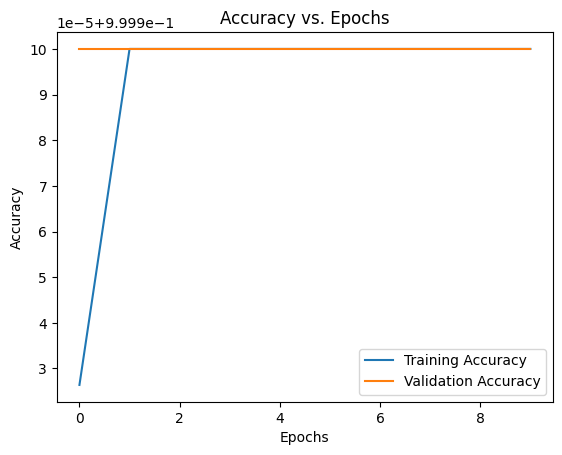

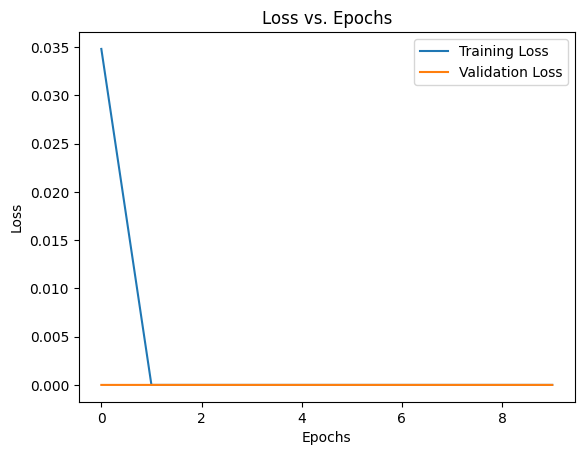

In [46]:
plot_accuracy(history)
plot_loss(history)

Unlike the previous models based on target prediction wherein the accuracy was really low, here the accuracies received were **REALLY** high, being at 100%, with accompanying non-existent losses. Obviously, this would make sense since this model is trying to group words that are closer to the `target_words`, however, even with a slight amount of similarity, that would count as positive response, highering the "accuracy". 

In such a senario, other evaluation metrics such as cosine similarity are frequently used, making it better to judge the performance of said models

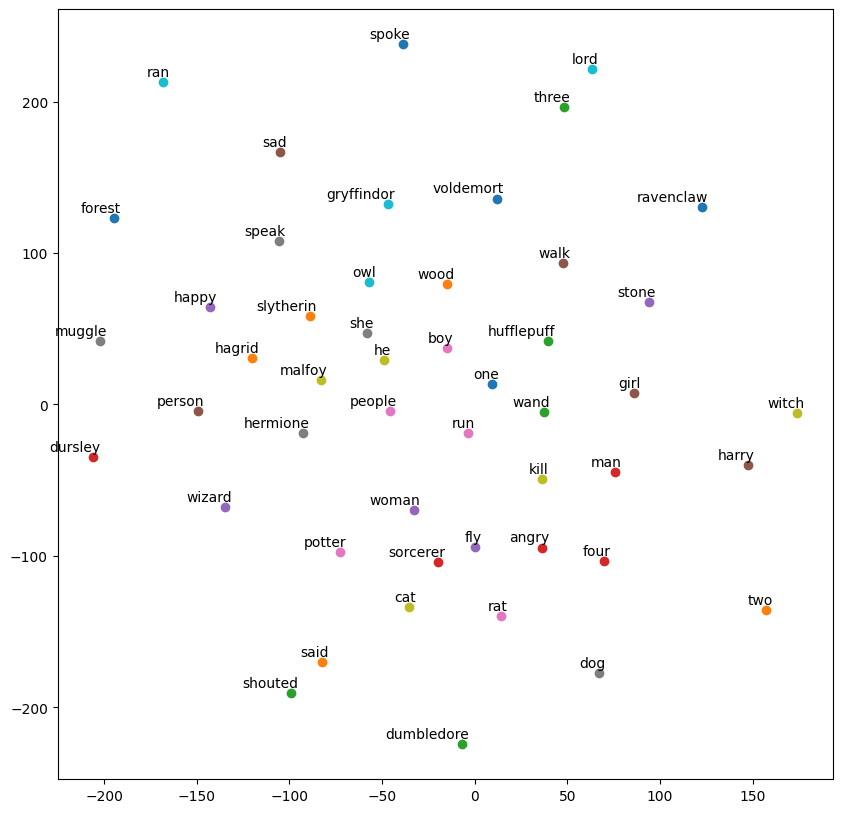

In [48]:
trained_embeddings = context_predictor_model.get_layer('shared_embedding').get_weights()[0]
visualize_tsne_embeddings(target_words, trained_embeddings, word_index)

We also see how evenly the "context words" are spread out from the target words. This would make sense, since those words apprear at a similar frequency of its counterparts around the target word

In [49]:
for _ in range(10):
    random_index = random.randint(0, len(target_words) - 1)
    word = target_words[random_index]
    closest_words = find_closest_words(word, word_index, trained_embeddings) # there is a default variable num_closest with value of 10
    print(f"Closest words to '{word}': {closest_words}")

Closest words to 'one': [('pupil', '43%'), ('suspended', '40%'), ('drafted', '40%'), ('items', '39%'), ('helpers', '37%'), ('wagged', '37%'), ('plenty', '37%'), ('mollen', '37%'), ('thousands', '36%'), ('delightful', '35%')]
Closest words to 'stone': [('doorway', '40%'), ('gentlest', '37%'), ('fluffys', '34%'), ('professor', '34%'), ('stories', '34%'), ('quills', '32%'), ('resolute', '32%'), ('baggins', '32%'), ('whatever', '31%'), ('pop', '31%')]
Closest words to 'owl': [('toasting', '49%'), ('peaks', '48%'), ('restored', '39%'), ('two', '39%'), ('leglocker', '38%'), ('belly', '38%'), ('clammy', '37%'), ('quieter', '37%'), ('bodybind', '37%'), ('forgetful', '37%')]
Closest words to 'girl': [('damnation', '40%'), ('uprising', '38%'), ('ridge', '37%'), ('footstool', '36%'), ('swarming', '35%'), ('released', '35%'), ('diversion', '35%'), ('underfed', '33%'), ('alone', '33%'), ('hesitatingly', '33%')]
Closest words to 'slytherin': [('beth', '48%'), ('pastures', '43%'), ('office', '42%'), 

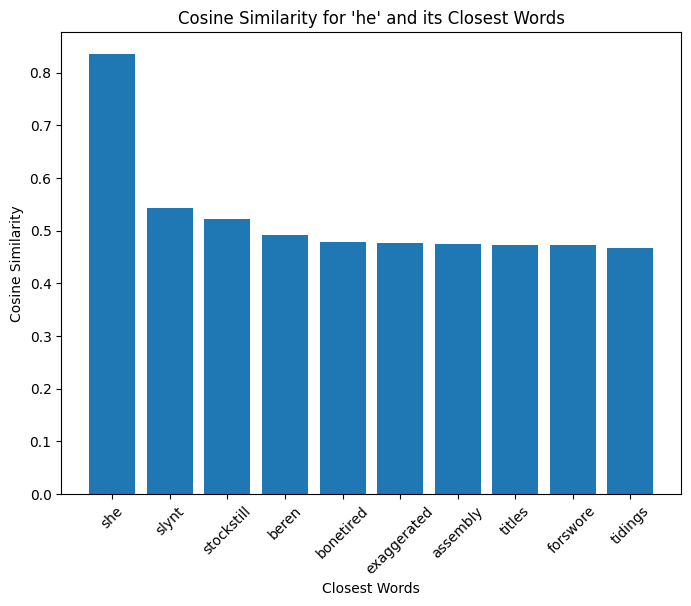

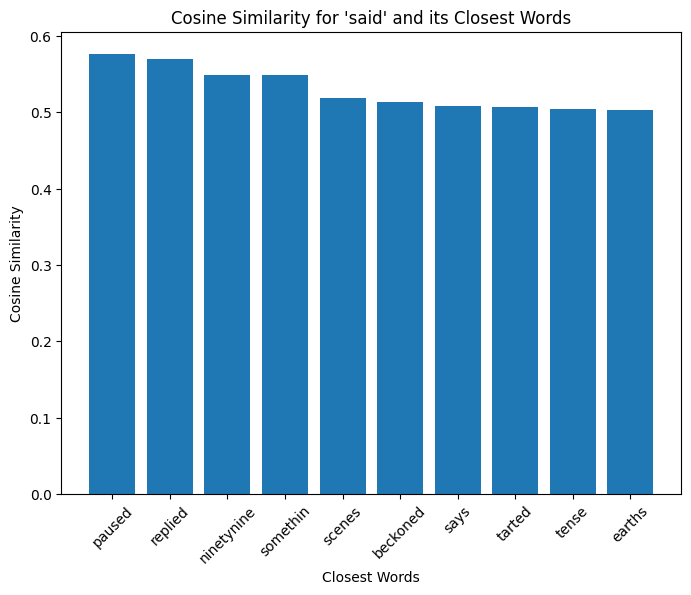

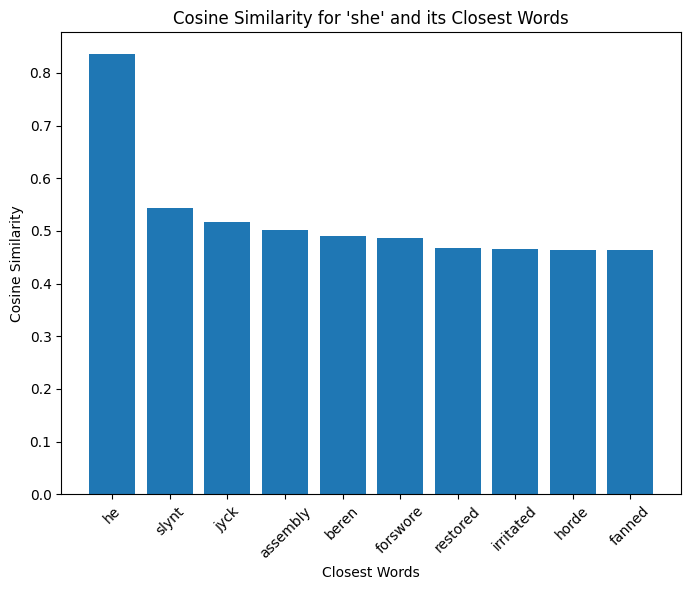

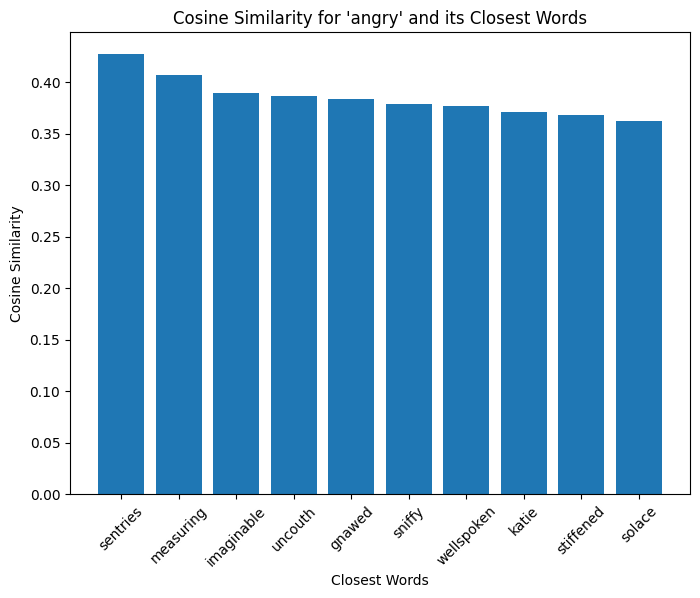

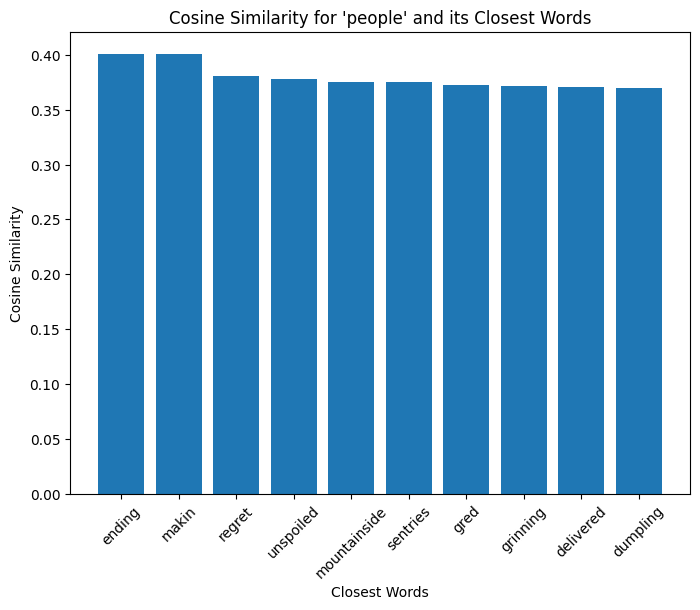

In [51]:
# Cosine Similarity

# Iterate over random target words and plot the cosine similarity graph
for _ in range(5):
    random_index = random.randint(0, len(target_words) - 1)
    word = target_words[random_index]
    closest_words = find_closest_words(word, word_index, trained_embeddings)
    similarities = calculate_cosine_similarity(word, closest_words, trained_embeddings, word_index)

    # Plot the cosine similarity graph
    plt.figure(figsize=(8, 6))
    plt.bar(similarities.keys(), similarities.values())
    plt.title(f"Cosine Similarity for '{word}' and its Closest Words")
    plt.xlabel("Closest Words")
    plt.ylabel("Cosine Similarity")
    plt.xticks(rotation=45)
    plt.show()

The cosine similarity above gives a better idea of how the model performed, which did not quite meet our expectations, since the similarity values were just about 40%

Another model for comparison with same features as the previous one but a different embedding output dimension:

In [52]:
embedding_output_dim = 50
lstm_neurons= 64
optimizer = 'adam'
activation='sigmoid'

context_predictor_model_2 = create_context_model(embedding_output_dim, vocab_size, activation, optimizer)

context_predictor_model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_word_input (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 context_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 shared_embedding (Embeddin  (None, 1, 50)                735500    ['target_word_input[0][0]',   
 g)                                                                  'context_input[0][0]']       
                                                                                            

In [54]:
history = context_predictor_model_2.fit([x_train, y_train], np.ones(len(y_train)), epochs=10, batch_size=32, validation_data=([x_val, y_val], np.ones(len(y_val))))
context_predictor_model_2.save('context_predictor_model_2.keras')

Epoch 1/10
32260/32260 [==============================] - 574s 18ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 8.3340e-08 - val_accuracy: 1.0000
Epoch 2/10
32260/32260 [==============================] - 635s 20ms/step - loss: 8.9826e-09 - accuracy: 1.0000 - val_loss: 7.1661e-09 - val_accuracy: 1.0000
Epoch 3/10
32260/32260 [==============================] - 690s 21ms/step - loss: 1.7037e-09 - accuracy: 1.0000 - val_loss: 3.6079e-09 - val_accuracy: 1.0000
Epoch 4/10
32260/32260 [==============================] - 586s 18ms/step - loss: 9.8010e-10 - accuracy: 1.0000 - val_loss: 2.4387e-09 - val_accuracy: 1.0000
Epoch 5/10
32260/32260 [==============================] - 615s 19ms/step - loss: 6.9590e-10 - accuracy: 1.0000 - val_loss: 1.8619e-09 - val_accuracy: 1.0000
Epoch 6/10
32260/32260 [==============================] - 465s 14ms/step - loss: 5.4382e-10 - accuracy: 1.0000 - val_loss: 1.5161e-09 - val_accuracy: 1.0000
Epoch 7/10
32260/32260 [==============================] - 2472

`Execution Time - 132 minutes`

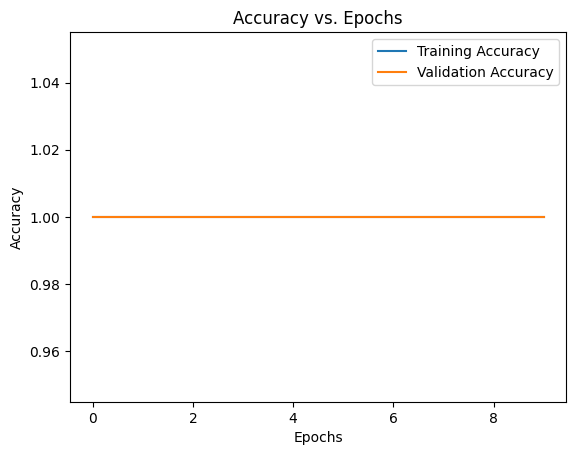

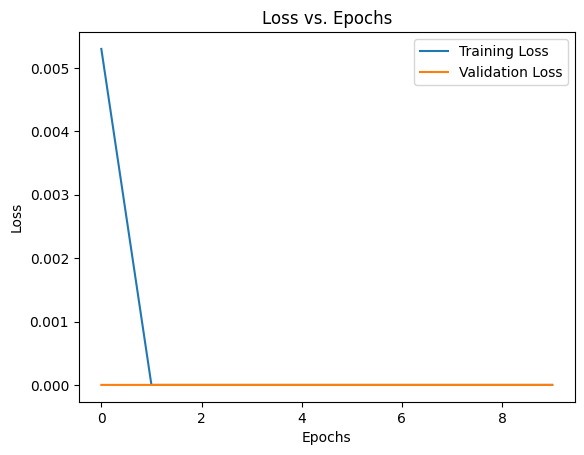

In [56]:
plot_accuracy(history)
plot_loss(history)

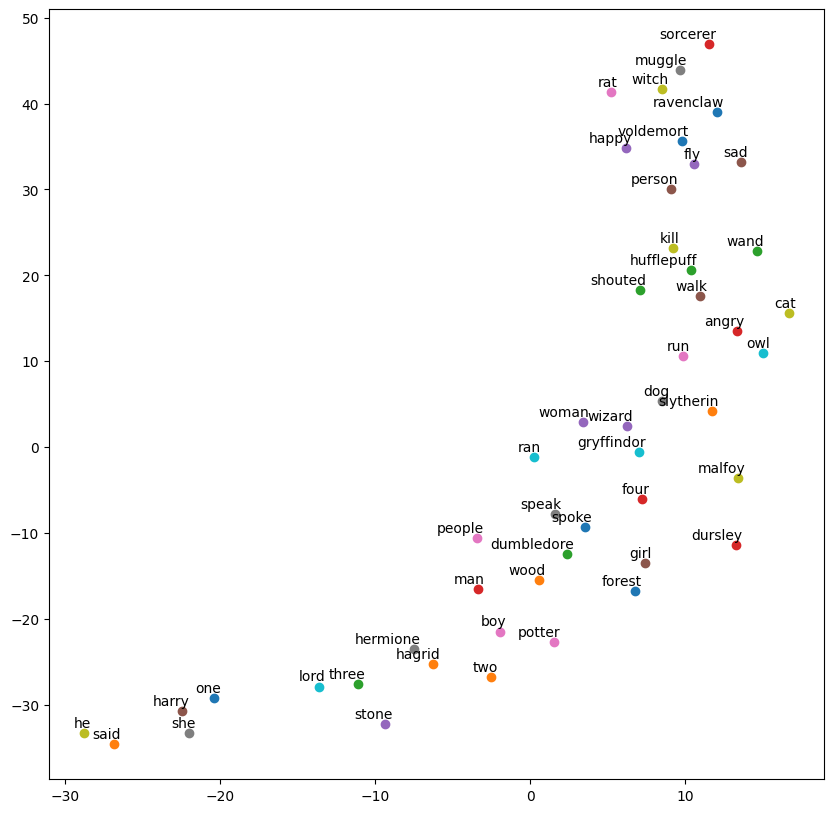

In [57]:
trained_embeddings = context_predictor_model_2.get_layer('shared_embedding').get_weights()[0]
visualize_tsne_embeddings(target_words, trained_embeddings, word_index)

In [58]:
for _ in range(10):
    random_index = random.randint(0, len(target_words) - 1)
    word = target_words[random_index]
    closest_words = find_closest_words(word, word_index, trained_embeddings) # there is a default variable num_closest with value of 10
    print(f"Closest words to '{word}': {closest_words}")

Closest words to 'spoke': [('really', '99%'), ('rivendell', '99%'), ('question', '99%'), ('showed', '99%'), ('strider', '99%'), ('lost', '99%'), ('rising', '99%'), ('wanted', '98%'), ('shall', '98%'), ('father', '98%')]
Closest words to 'she': [('going', '98%'), ('talk', '98%'), ('winterfell', '98%'), ('turned', '98%'), ('already', '98%'), ('come', '98%'), ('said', '98%'), ('well', '98%'), ('arya', '98%'), ('gone', '98%')]
Closest words to 'rat': [('waved', '98%'), ('percys', '98%'), ('boffin', '97%'), ('heading', '97%'), ('northward', '97%'), ('climbing', '97%'), ('shaking', '97%'), ('ragged', '97%'), ('frozen', '97%'), ('strive', '97%')]
Closest words to 'run': [('work', '98%'), ('heard', '98%'), ('theyre', '98%'), ('eight', '98%'), ('stout', '98%'), ('lot', '98%'), ('leaving', '98%'), ('hide', '98%'), ('head', '98%'), ('somehow', '98%')]
Closest words to 'wand': [('smelling', '98%'), ('mouth', '98%'), ('gate', '98%'), ('deep', '98%'), ('tangled', '98%'), ('piles', '98%'), ('used', '

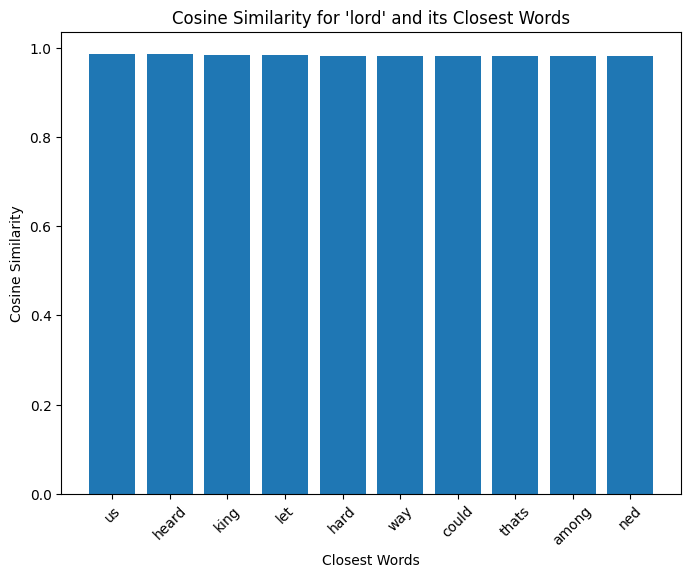

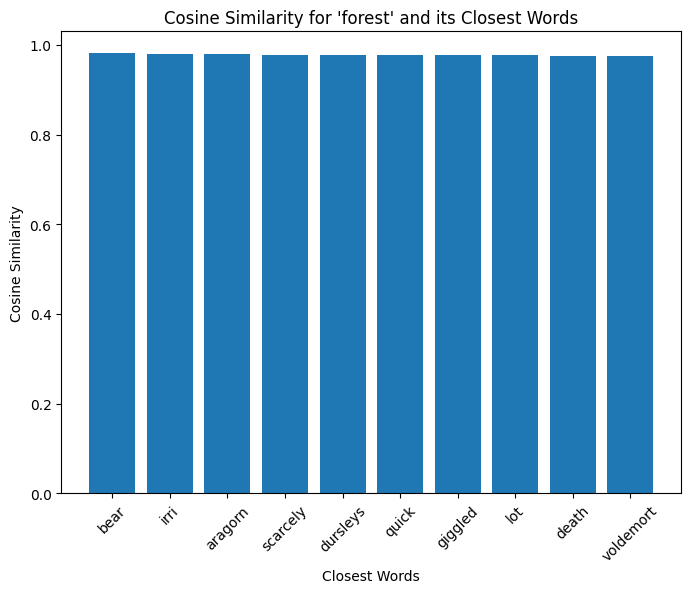

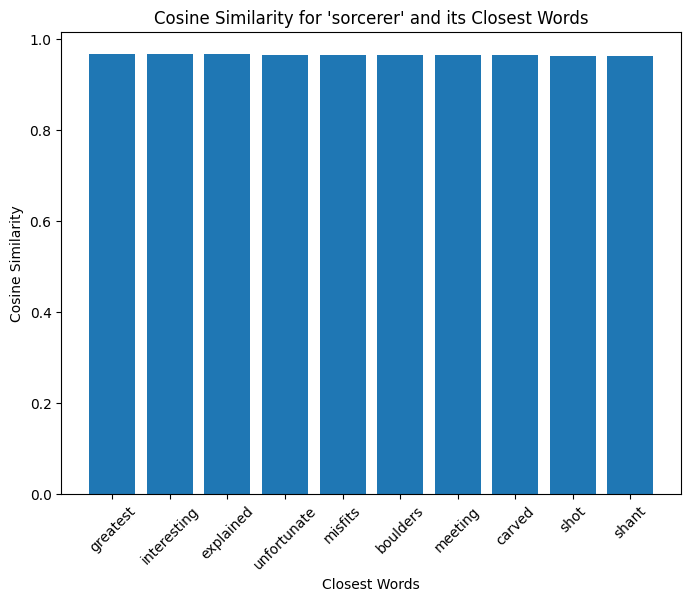

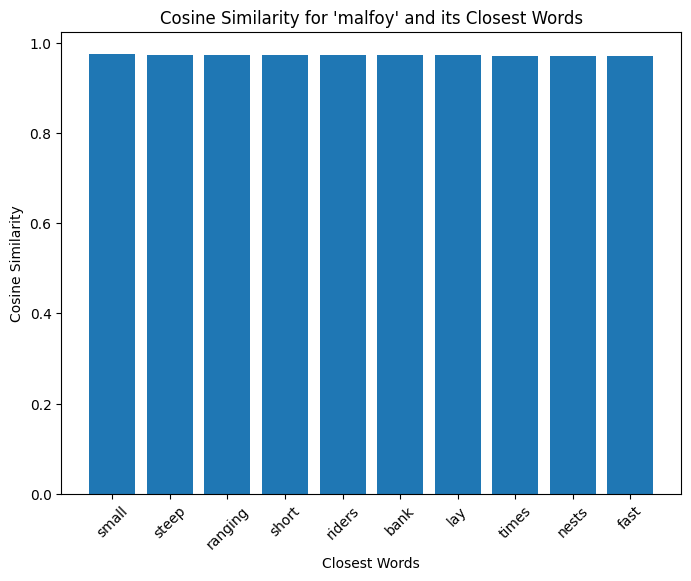

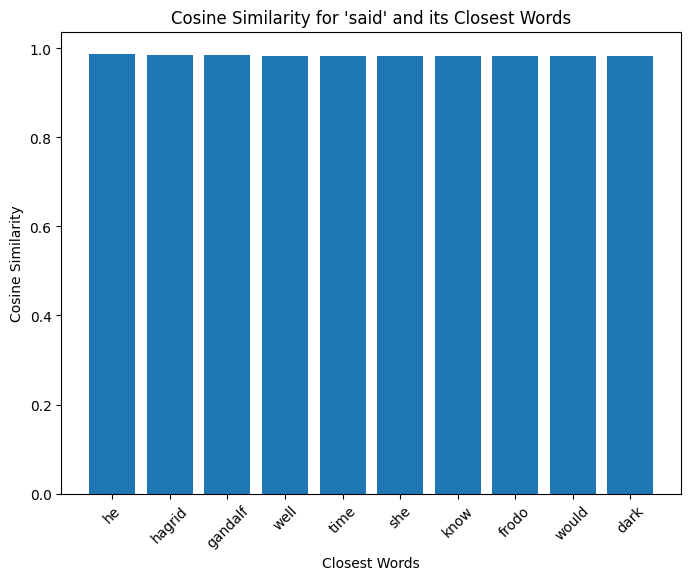

In [59]:
for _ in range(5):
    random_index = random.randint(0, len(target_words) - 1)
    word = target_words[random_index]
    closest_words = find_closest_words(word, word_index, trained_embeddings)
    similarities = calculate_cosine_similarity(word, closest_words, trained_embeddings, word_index)

    # Plot the cosine similarity graph
    plt.figure(figsize=(8, 6))
    plt.bar(similarities.keys(), similarities.values())
    plt.title(f"Cosine Similarity for '{word}' and its Closest Words")
    plt.xlabel("Closest Words")
    plt.ylabel("Cosine Similarity")
    plt.xticks(rotation=45)
    plt.show()

With the above, it's clear that the model with a lower embedding output dimension has a better performance than that with a higher embedding output dimension.

### Conclusion

From the above experiments, it's clear that the models with lower embedding size were ultimately better in performance while being computationally efficient. For the first model, named `text_predictor_model_2` was better able to group the target words compared to its context words, which could be visualised with the tighter grouping in the t-SNE graph. 

While for the second model, the `context_predictor_model_2` achieved better results as we received a better similarity of words given the target word, as is evident from the cosine graph

While other models were also created by changing other hyperparameters such as the lstm neural size, window size and other activation features, the best results were obtained by changing the output embedding layer alone.